In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
pip install git+https://github.com/thuml/Large-Time-Series-Model.git

  Cloning https://github.com/thuml/Large-Time-Series-Model.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-12mphzfm
  Running command git clone --filter=blob:none --quiet https://github.com/thuml/Large-Time-Series-Model.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-12mphzfm
  Resolved https://github.com/thuml/Large-Time-Series-Model.git to commit 8a450f43b137404528cc46dee02436d34d84607a
ERROR: git+https://github.com/thuml/Large-Time-Series-Model.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


# Testing the model: context 1440(max) prediction 96

#### HF: https://huggingface.co/thuml/timer-base-84m
#### Gitub: https://github.com/thuml/Large-Time-Series-Model

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating forecast for recent period...
Input tensor shape: torch.Size([1, 1440])
Output tensor shape: torch.Size([1, 96])

Full Period Metrics:
MAE: 427.3340
MSE: 248411.2769
RMSE: 498.4087
MAPE: 7.3153
SMAPE: 7.5920
MASE: 13.4441


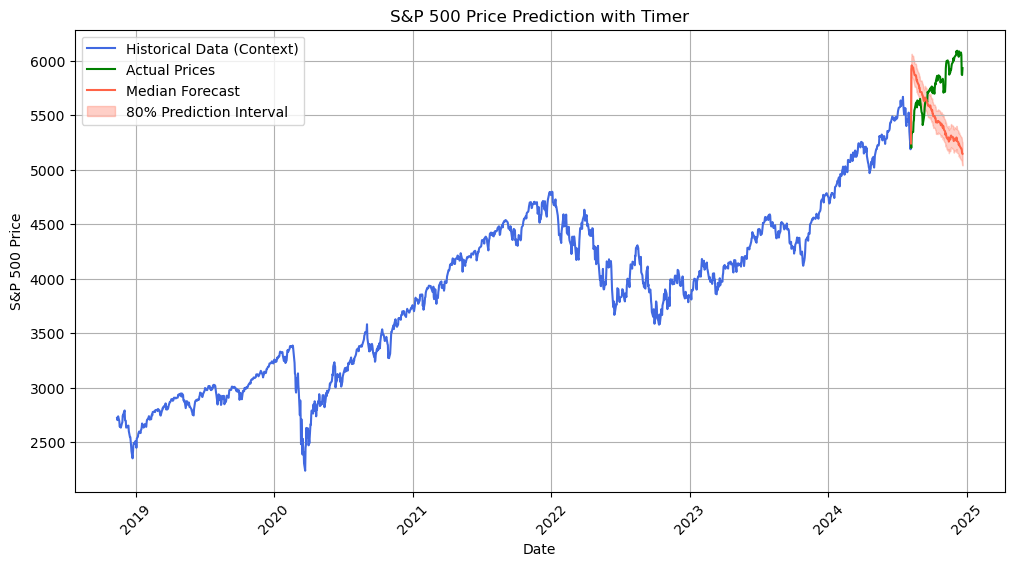


Generating forecast for COVID-19 period...
Input tensor shape: torch.Size([1, 369])
Output tensor shape: torch.Size([1, 96])

COVID Period Metrics:
MAE: 194.8041
MSE: 55608.4182
RMSE: 235.8144
MAPE: 4.2014
SMAPE: 4.3328
MASE: 5.5368


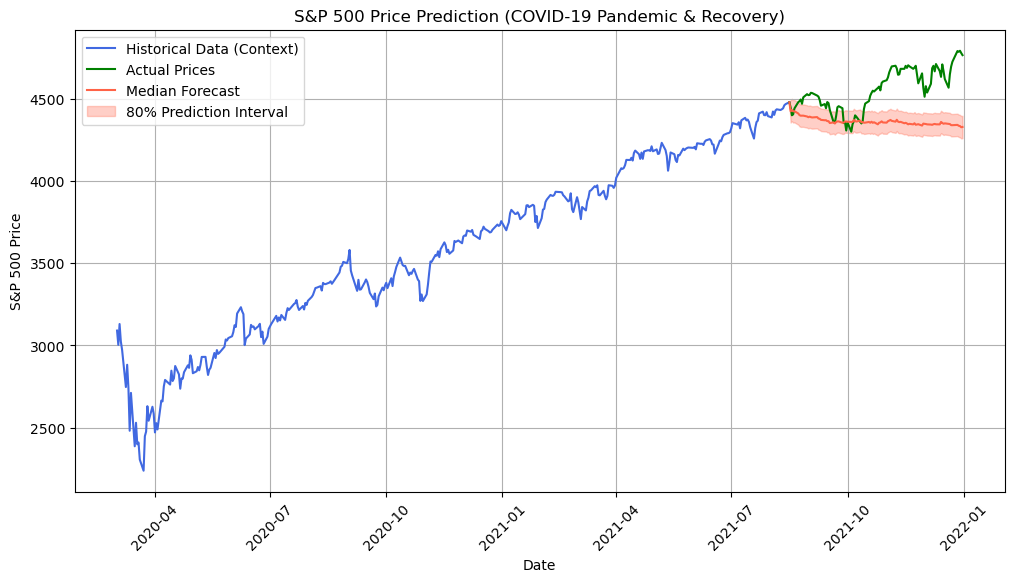

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM

from data.snp500 import snp500_daily
from utils.metrics import metric

CONTEXT_WINDOW = 1440 # Maximum context winodw mentioned in the paper
PREDICTION_WINDOW = 96

# Initialize Timer model
model = AutoModelForCausalLM.from_pretrained('thuml/timer-base-84m', trust_remote_code=True)
model.eval()

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]

def normalize_data(data):
    """Normalize the input data to have zero mean and unit variance"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return (data * std) + mean

def generate_forecast(context_data):
    """Generate and process forecast using Timer"""
    # Normalize the context data
    context_norm, mean, std = normalize_data(context_data)
    
    # Prepare input tensor with correct shape [batch_size, seq_len]
    context_tensor = torch.tensor(context_norm, dtype=torch.float32)
    context_tensor = context_tensor.reshape(1, -1)  # Ensure shape is [1, seq_len]
    print(f"Input tensor shape: {context_tensor.shape}")  # Debug print
    
    # Generate forecast
    with torch.no_grad():
        try:
            output = model.generate(
                context_tensor, 
                max_new_tokens=PREDICTION_WINDOW,
                pad_token_id=model.config.pad_token_id if hasattr(model.config, 'pad_token_id') else None,
                bos_token_id=model.config.bos_token_id if hasattr(model.config, 'bos_token_id') else None,
                eos_token_id=model.config.eos_token_id if hasattr(model.config, 'eos_token_id') else None
            )
            print(f"Output tensor shape: {output.shape}")  # Debug print
        except Exception as e:
            print(f"Error during generation: {str(e)}")
            raise
    
    # Extract predictions and denormalize
    predictions = output[0, -PREDICTION_WINDOW:].cpu().numpy()
    predictions_denorm = denormalize_data(predictions, mean, std)
    
    # Generate confidence intervals (using model's internal variance or simple heuristic)
    std_dev = std * 0.1  # Simple heuristic for uncertainty
    low = predictions_denorm - 1.28 * std_dev  # 80% confidence interval
    high = predictions_denorm + 1.28 * std_dev
    
    return low, predictions_denorm, high

def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Calculate basic metrics
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }

    return metrics

def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Generate full period forecast
print("Generating forecast for recent period...")
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Timer",
)

# COVID-19 Period Analysis
print("\nGenerating forecast for COVID-19 period...")
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly
## Timer weekly context window input length must be divisible by input_token_len


Running daily frequency experiments...
Input tensor shape: torch.Size([1, 96])


/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 192])
Input tensor shape: torch.Size([1, 192])
Input tensor shape: torch.Size([1, 192])
Input tensor shape: torch.Size([1, 192])
Input tensor shape: torch.Size([1, 192])
Input tensor shape: torch.Size([1, 384])
Input tensor shape: torch.Size([1, 384])
Input tensor shape: torch.Size([1, 384])
Input tensor shape: torch.Size([1, 384])
Input tensor shape: torch.Size([1, 384])


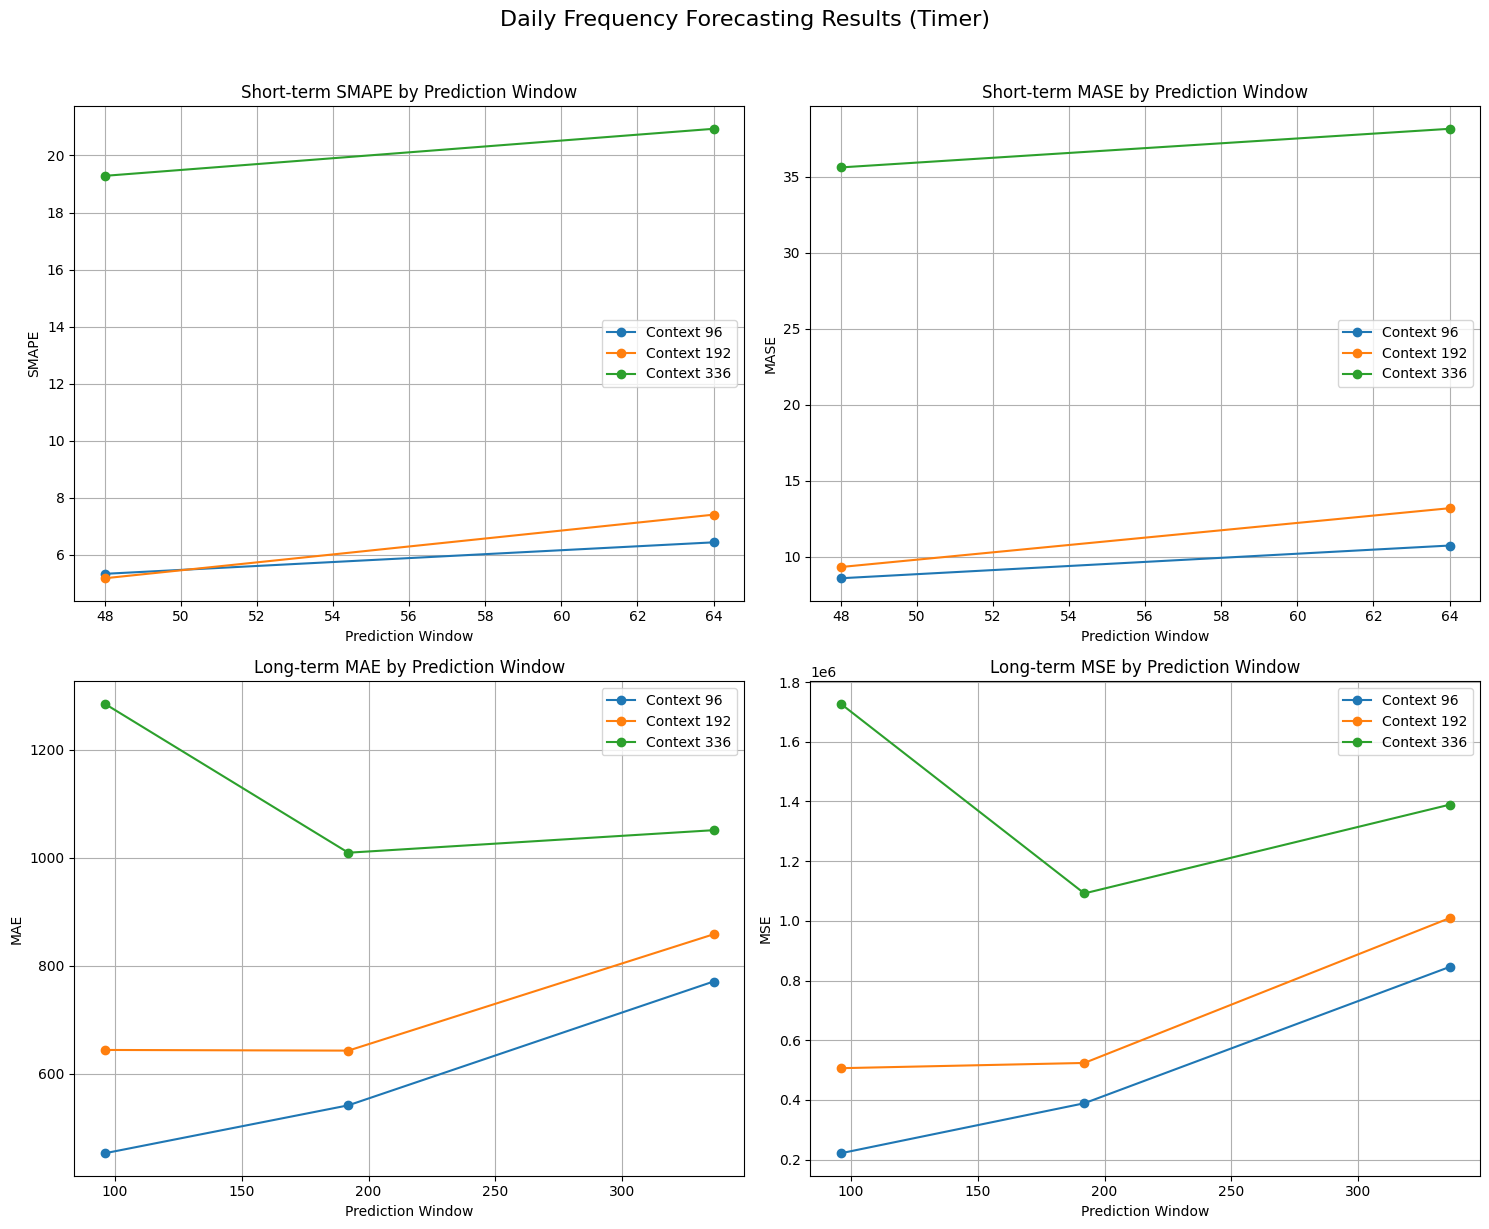


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
96             48                  308.9016   5.1623   8.5923  1.228663e+05   
               64                  368.3940   6.2067  10.7433  1.612180e+05   
192            48                  299.9172   5.0049   9.3305  1.245930e+05   
               64                  421.0304   7.0828  13.1978  2.239092e+05   
336            48                 1044.0688  17.5698  35.6092  1.107743e+06   
               64                 1116.4587  18.9261  38.1481  1.268557e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
96             48                  350.5228   5.3388  
               64                  401.5197   6.4423  
192            48                  352.9774   5.1837  
               64                

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])


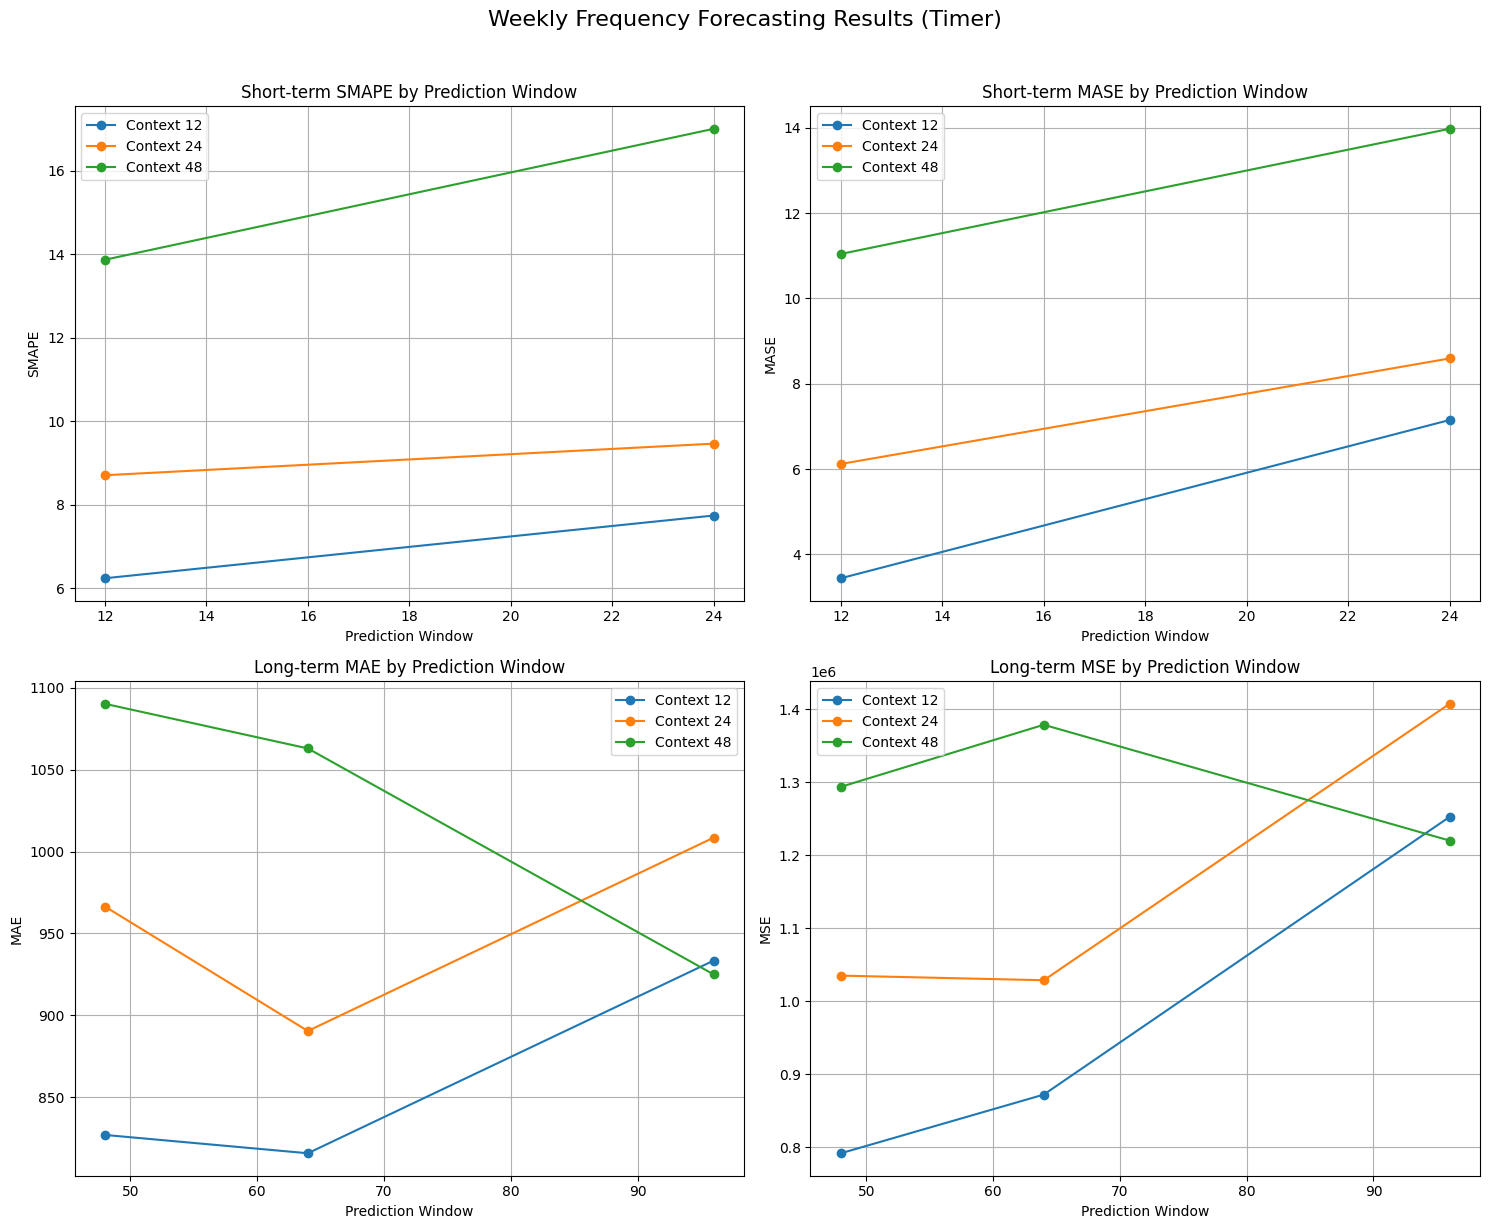


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE     MAPE     MASE          MSE  \
Context Window Prediction Window                                            
12             12                 358.3111   6.0284   3.4418  141415.5991   
               24                 430.7331   7.3857   7.1501  231949.8497   
24             12                 493.8954   8.3250   6.1205  256200.0541   
               24                 521.2501   8.9857   8.5927  307618.7337   
48             12                 767.3871  12.9538  11.0420  602092.1837   
               24                 901.6092  15.6277  13.9749  852901.3411   

Metric                                RMSE    SMAPE  
Context Window Prediction Window                     
12             12                 376.0527   6.2338  
               24                 481.6117   7.7374  
24             12                 506.1621   8.7032  
               24                 554.6339   9.4600  

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])


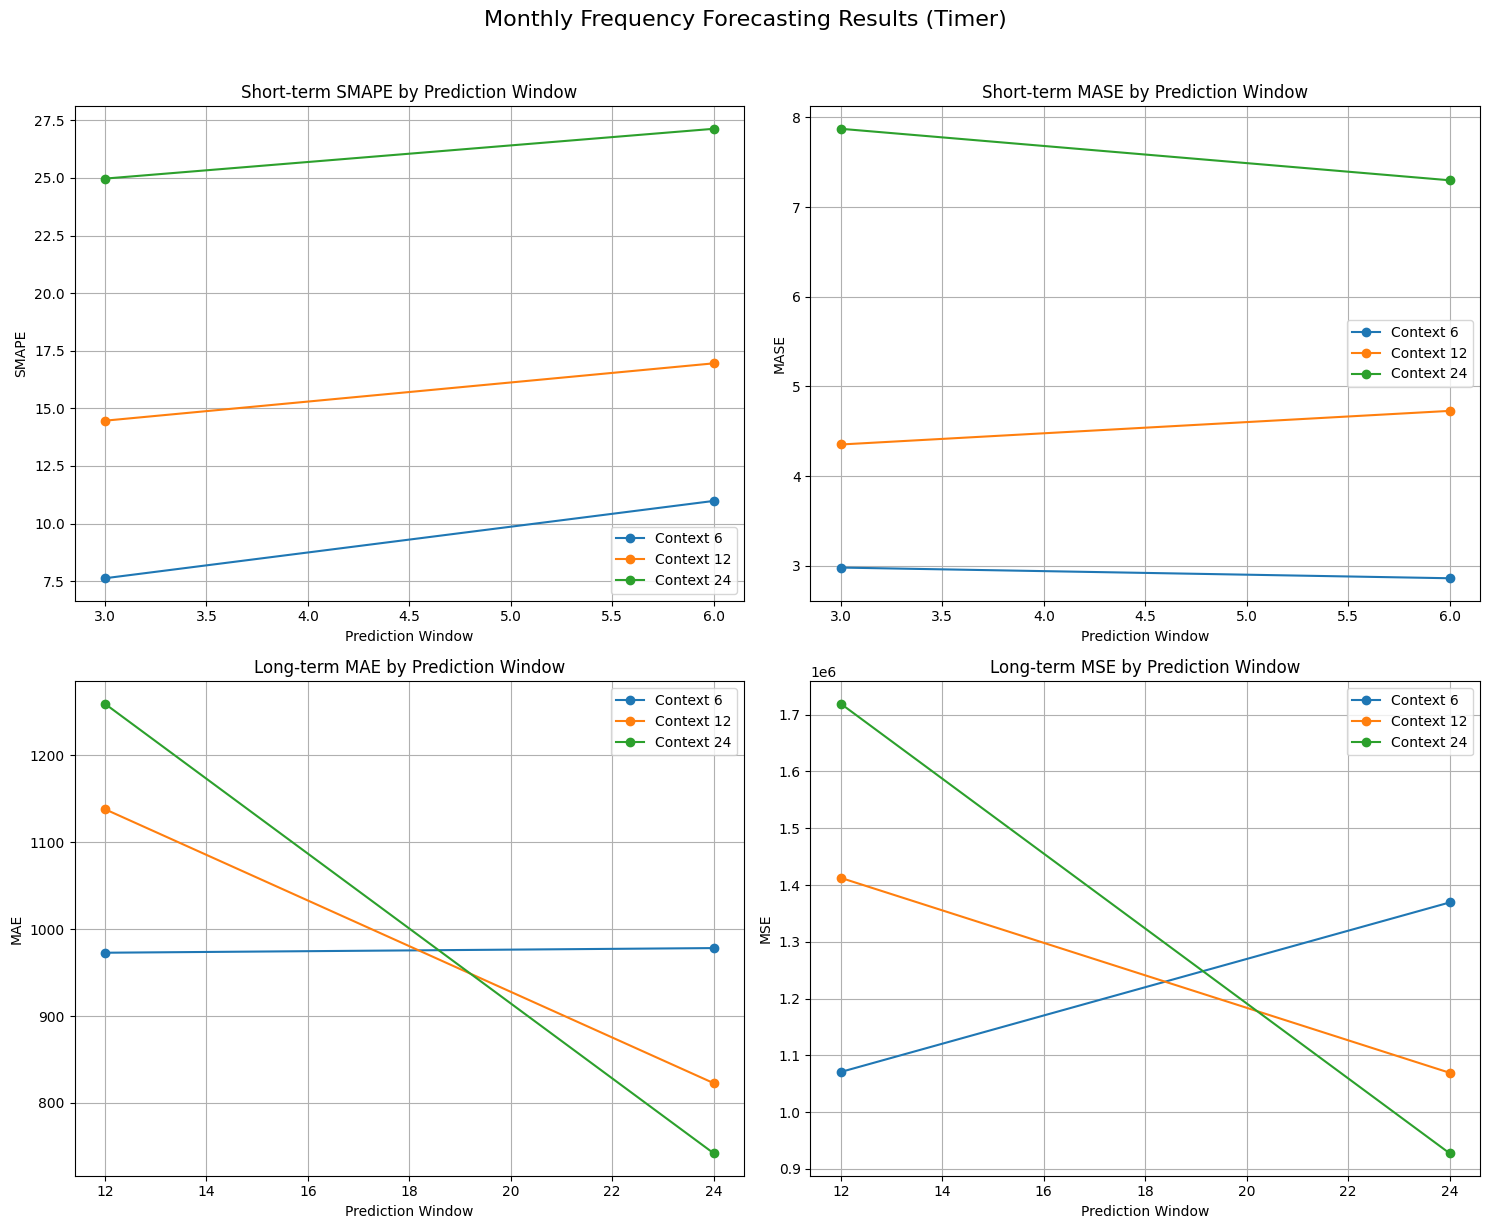


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE    MASE           MSE  \
Context Window Prediction Window                                             
6              3                   432.9478   7.3253  2.9785  2.041519e+05   
               6                   601.6901  10.3773  2.8593  3.881982e+05   
12             3                   793.5864  13.4706  4.3517  6.455865e+05   
               6                   901.9718  15.6058  4.7265  8.335880e+05   
24             3                  1305.0361  22.1802  7.8735  1.720812e+06   
               6                  1377.7590  23.8577  7.2993  1.928979e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
6              3                   451.8317   7.6270  
               6                   623.0555  10.9819  
12             3                   803.4840  14.4641  
               6                   913.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.evaluate import ContextPredictionWindowEvaluator
from utils.normalizer import Normalizer

def timer_forecast(model, context, prediction_window):
    """Forecast function for Timer model"""
    # Initialize normalizer
    normalizer = Normalizer(norm_type="standardization")
    
    # Ensure data is 1D and normalize
    context = np.asarray(context).flatten()
    context_normalized = normalizer.normalize(pd.DataFrame(context, columns=["value"])).values.flatten()
    
    # Timer requires input length to be divisible by 96 (default input_token_len)
    input_token_len = 96
    cur_len = len(context_normalized)
    if cur_len < input_token_len:
        # Pad with zeros if context is too short
        pad_length = input_token_len - cur_len
        context_normalized = np.pad(context_normalized, (0, pad_length), mode='constant')
    elif cur_len % input_token_len != 0:
        # Pad to next multiple of input_token_len
        new_len = ((cur_len // input_token_len) + 1) * input_token_len
        pad_length = new_len - cur_len
        context_normalized = np.pad(context_normalized, (0, pad_length), mode='constant')
    
    # Prepare input tensor with correct shape [batch_size, seq_len]
    context_tensor = torch.tensor(context_normalized, dtype=torch.float32)
    context_tensor = context_tensor.reshape(1, -1)  # Ensure shape is [1, seq_len]
    print(f"Input tensor shape: {context_tensor.shape}")  # Debug print
    
    # Initialize model if None (first call)
    if model is None:
        model = AutoModelForCausalLM.from_pretrained('thuml/timer-base-84m', trust_remote_code=True)
        model.eval()
    
    # Generate forecast
    with torch.no_grad():
        try:
            output = model.generate(
                context_tensor,
                max_new_tokens=prediction_window,
                pad_token_id=model.config.pad_token_id if hasattr(model.config, 'pad_token_id') else None,
                bos_token_id=model.config.bos_token_id if hasattr(model.config, 'bos_token_id') else None,
                eos_token_id=model.config.eos_token_id if hasattr(model.config, 'eos_token_id') else None
            )
        except Exception as e:
            print(f"Error during generation: {str(e)}")
            raise
    
    # Extract predictions
    predictions = output[0, -prediction_window:].cpu().numpy()
    
    # Denormalize predictions
    predictions_denorm = normalizer.denormalize(pd.DataFrame(predictions, columns=["value"])).values.flatten()
    
    # Generate confidence intervals
    std_dev = np.std(context) * 0.1  # Use historical volatility for uncertainty
    low = predictions_denorm - 1.28 * std_dev  # 80% confidence interval
    high = predictions_denorm + 1.28 * std_dev
    
    return low, predictions_denorm, high

def plot_results_by_frequency(results_df, frequency):
    """Create plots for short-term and long-term metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"{frequency.capitalize()} Frequency Forecasting Results (Timer)", 
        fontsize=16, 
        y=1.02
    )

    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df["Horizon"] == "short_term"]
    context_windows = sorted(short_term["Context Window"].unique())

    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context)
            & (short_term["Metric"] == "SMAPE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("SMAPE")
    ax.set_title("Short-term SMAPE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context) & (short_term["Metric"] == "MASE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MASE")
    ax.set_title("Short-term MASE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df["Horizon"] == "long_term"]

    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MAE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MAE")
    ax.set_title("Long-term MAE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MSE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MSE")
    ax.set_title("Long-term MSE by Prediction Window")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Initialize experiment runner with dummy model
dummy_model = None  # Model will be created in timer_forecast

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model, forecast_fn=timer_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly,
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")

    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)

# Forecasting visuals of best performing runs for recent and COVID-19 periods

Generating plots for extended period...
Input tensor shape: torch.Size([1, 96])


/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])


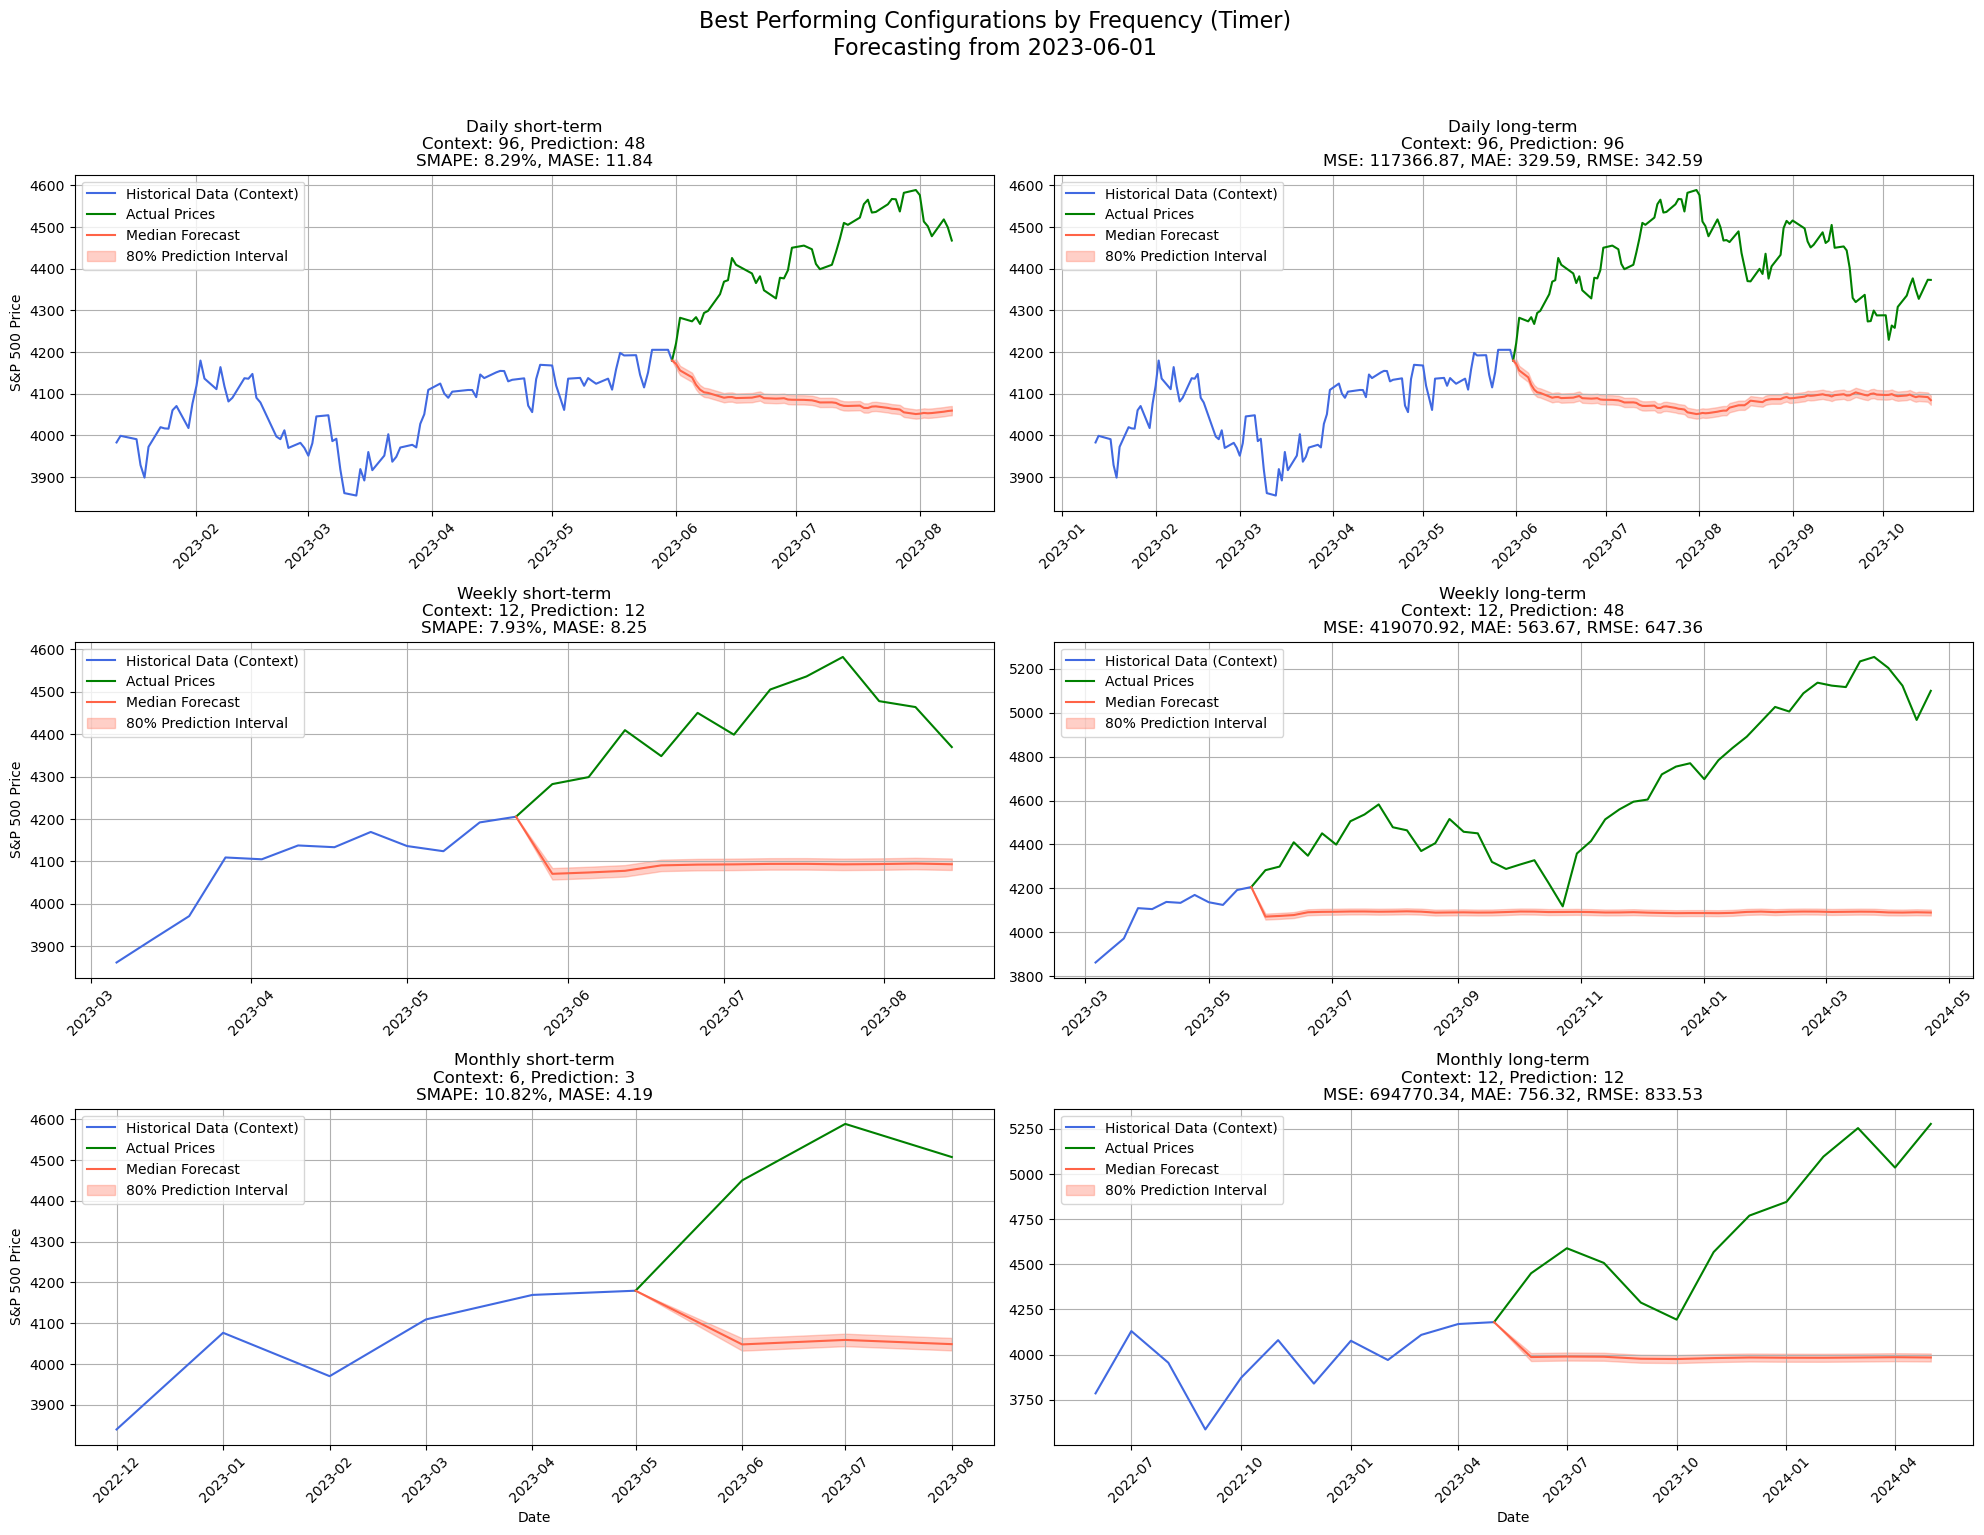


Generating plots for COVID period...
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])
Input tensor shape: torch.Size([1, 96])


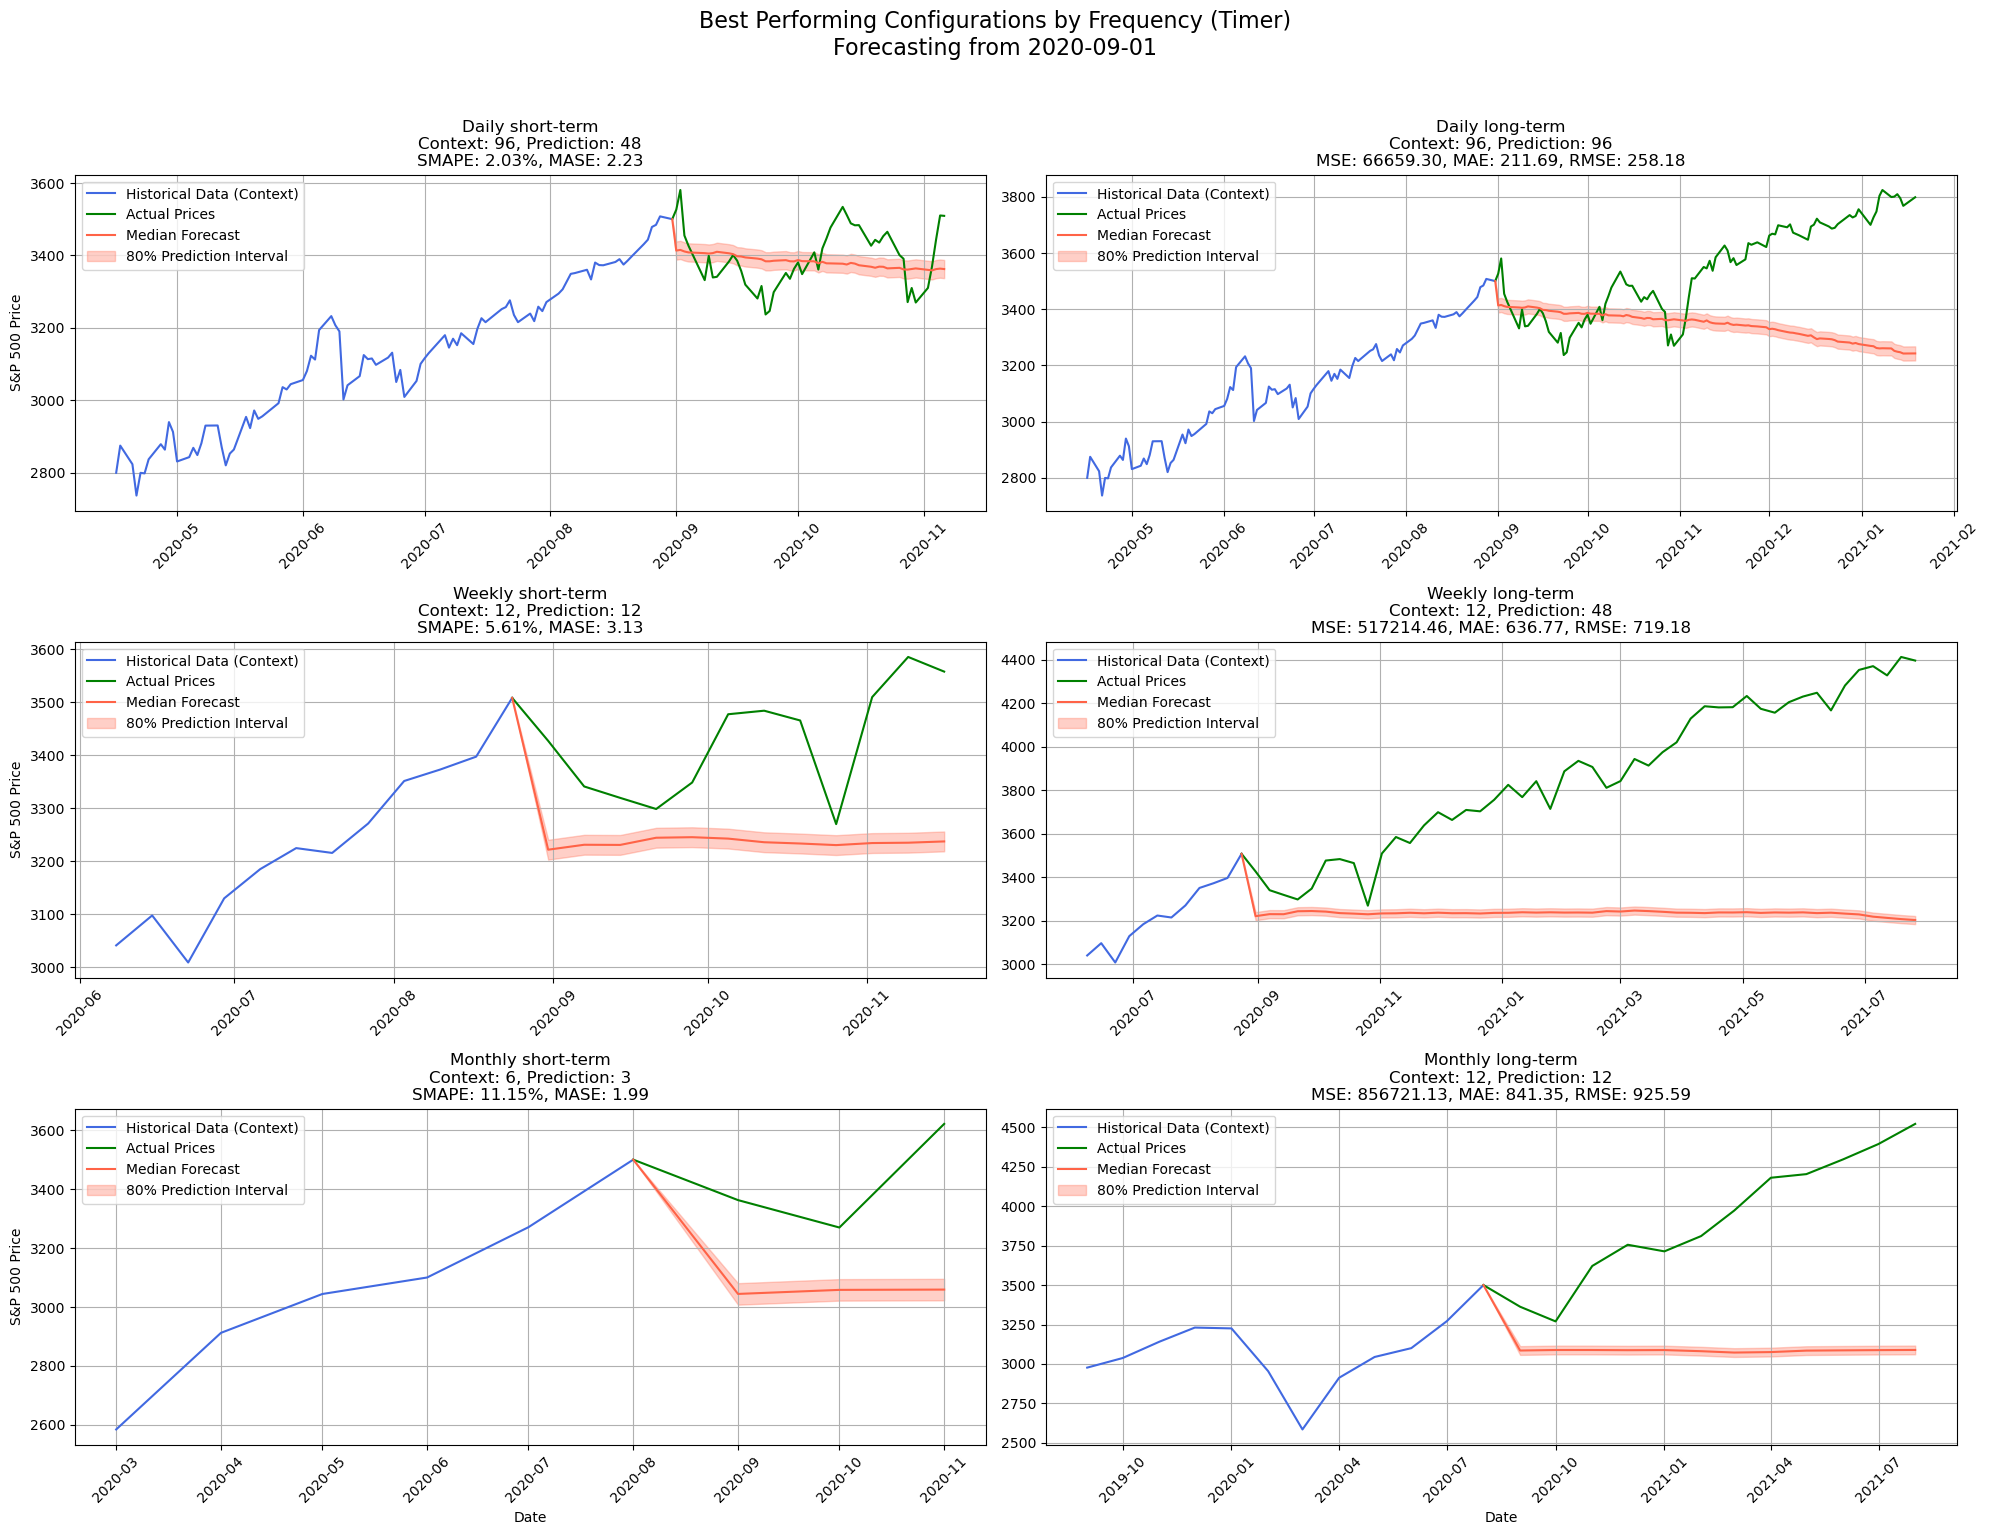


Metrics Comparison - Extended Period vs COVID Period:

Daily Frequency Results:

Short-term metrics:
Extended Period (forecast from 2023-06-01):
context: 96.0000
prediction: 48.0000
MSE: 7033.3632
MAE: 69.0966
RMSE: 83.8651
SMAPE: 2.0344
MASE: 2.2276

COVID Period (forecast from 2020-09-01):
context: 96.0000
prediction: 48.0000
MSE: 7033.3632
MAE: 69.0966
RMSE: 83.8651
SMAPE: 2.0344
MASE: 2.2276

Long-term metrics:
Extended Period (forecast from 2023-06-01):
context: 96.0000
prediction: 96.0000
MSE: 66659.2982
MAE: 211.6923
RMSE: 258.1846
SMAPE: 6.0674
MASE: 6.8247

COVID Period (forecast from 2020-09-01):
context: 96.0000
prediction: 96.0000
MSE: 66659.2982
MAE: 211.6923
RMSE: 258.1846
SMAPE: 6.0674
MASE: 6.8247

Weekly Frequency Results:

Short-term metrics:
Extended Period (forecast from 2023-06-01):
context: 12.0000
prediction: 12.0000
MSE: 45722.0592
MAE: 188.3989
RMSE: 213.8272
SMAPE: 5.6142
MASE: 3.1292

COVID Period (forecast from 2020-09-01):
context: 12.0000
prediction: 12.0

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.metrics import metric
from utils.normalizer import Normalizer

def calculate_metrics(actual, predicted, insample=None):
    """Calculate metrics dynamically"""
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE if insample data is provided
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "SMAPE": smape, "MASE": mase}

def generate_timer_forecast(context, prediction_window):
    """Generate forecast using Timer model"""
    # Initialize normalizer
    normalizer = Normalizer(norm_type="standardization")
    
    # Normalize the context data
    context_normalized = normalizer.normalize(pd.DataFrame(context, columns=["value"])).values.flatten()
    
    # Timer requires input length to be divisible by 96
    input_token_len = 96
    cur_len = len(context_normalized)
    if cur_len < input_token_len:
        pad_length = input_token_len - cur_len
        context_normalized = np.pad(context_normalized, (0, pad_length), mode='constant')
    elif cur_len % input_token_len != 0:
        new_len = ((cur_len // input_token_len) + 1) * input_token_len
        pad_length = new_len - cur_len
        context_normalized = np.pad(context_normalized, (0, pad_length), mode='constant')
    
    # Prepare input tensor
    context_tensor = torch.tensor(context_normalized, dtype=torch.float32).reshape(1, -1)
    print(f"Input tensor shape: {context_tensor.shape}")
    
    # Initialize model
    model = AutoModelForCausalLM.from_pretrained('thuml/timer-base-84m', trust_remote_code=True)
    model.eval()
    
    # Generate forecast
    with torch.no_grad():
        output = model.generate(
            context_tensor,
            max_new_tokens=prediction_window,
            pad_token_id=model.config.pad_token_id if hasattr(model.config, 'pad_token_id') else None,
            bos_token_id=model.config.bos_token_id if hasattr(model.config, 'bos_token_id') else None,
            eos_token_id=model.config.eos_token_id if hasattr(model.config, 'eos_token_id') else None
        )
    
    # Extract predictions
    predictions = output[0, -prediction_window:].cpu().numpy()
    predictions_denorm = normalizer.denormalize(pd.DataFrame(predictions, columns=["value"])).values.flatten()
    
    # Generate confidence intervals
    std_dev = np.std(context) * 0.1
    low = predictions_denorm - 1.28 * std_dev
    high = predictions_denorm + 1.28 * std_dev
    
    return low, predictions_denorm, high

def plot_best_configs(data_dict, configs_dict, forecast_point, time_period):
    """Plot best performing configurations for each frequency"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(
        f"Best Performing Configurations by Frequency (Timer)\nForecasting from {forecast_point}",
        fontsize=16,
        y=1.02,
    )

    plot_idx = 1
    for freq in ["daily", "weekly", "monthly"]:
        data = data_dict[freq].copy()
        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()
        if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
            data["Date"] = pd.to_datetime(data["Date"])

        # Filter data for the specified period
        period_data = data[
            (data["Date"] >= time_period[0]) & (data["Date"] <= time_period[1])
        ].reset_index(drop=True)

        # Find the forecast start point
        forecast_start_idx = period_data[period_data["Date"] <= forecast_point].index[-1]

        for term in ["short", "long"]:
            ax = plt.subplot(3, 2, plot_idx)
            
            context_window = configs_dict[freq][term]["context"]
            prediction_window = configs_dict[freq][term]["prediction"]

            # Check if we have enough data
            if forecast_start_idx < context_window:
                ax.text(
                    0.5, 0.5,
                    f"Insufficient historical data for {freq} {term}-term\n"
                    f"Need {context_window} points before {forecast_point}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Get data windows
            window_start = forecast_start_idx - context_window
            window_end = min(forecast_start_idx + prediction_window + 1, len(period_data))
            window_data = period_data.iloc[window_start:window_end].copy()

            if len(window_data) < context_window + prediction_window:
                ax.text(
                    0.5, 0.5,
                    f"Insufficient data for full prediction window\n"
                    f"Need {context_window + prediction_window} points, have {len(window_data)}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Generate forecast
            context = window_data["Close"].values[:context_window]
            low, median, high = generate_timer_forecast(context, prediction_window)

            # Calculate metrics
            actual_values = window_data["Close"].values[
                context_window : context_window + prediction_window
            ]
            insample_data = window_data["Close"].values[:context_window]
            metrics = calculate_metrics(actual_values, median, insample=insample_data)
            configs_dict[freq][term].update(metrics)

            # Prepare plotting data
            last_context_point = window_data["Close"].iloc[context_window - 1]
            plot_actual = np.insert(actual_values[:prediction_window], 0, last_context_point)
            plot_median = np.insert(median[:prediction_window], 0, last_context_point)
            plot_low = np.insert(low[:prediction_window], 0, last_context_point)
            plot_high = np.insert(high[:prediction_window], 0, last_context_point)

            # Get dates
            historical_dates = window_data["Date"].iloc[:context_window]
            forecast_dates = window_data["Date"].iloc[
                context_window - 1 : context_window + prediction_window
            ]

            # Plot
            ax.plot(
                historical_dates,
                window_data["Close"].iloc[:context_window],
                color="royalblue",
                label="Historical Data (Context)",
            )
            ax.plot(forecast_dates, plot_actual, color="green", label="Actual Prices")
            ax.plot(
                forecast_dates, plot_median, color="tomato", label="Median Forecast"
            )
            ax.fill_between(
                forecast_dates,
                plot_low,
                plot_high,
                color="tomato",
                alpha=0.3,
                label="80% Prediction Interval",
            )

            if term == "short":
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'SMAPE: {metrics["SMAPE"]:.2f}%, MASE: {metrics["MASE"]:.2f}'
                )
            else:
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'MSE: {metrics["MSE"]:.2f}, MAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}'
                )

            ax.set_title(title)
            ax.tick_params(axis="x", rotation=45)
            if plot_idx % 2 == 1:
                ax.set_ylabel("S&P 500 Price")
            if plot_idx >= 5:
                ax.set_xlabel("Date")
            ax.grid(True)
            ax.legend(loc="upper left")

            plot_idx += 1

    plt.tight_layout()
    plt.show()
    return configs_dict

# Define configurations based on best performing settings
configs_dict = {
    "daily": {
        "short": {"context": 96, "prediction": 48},    # Best SMAPE/MASE combination
        "long": {"context": 96, "prediction": 96},     # Best RMSE for longer horizon
    },
    "weekly": {
        "short": {"context": 12, "prediction": 12},    # Best overall short-term metrics
        "long": {"context": 12, "prediction": 48},     # Best long-term performance
    },
    "monthly": {
        "short": {"context": 6, "prediction": 3},      # Best short-term metrics
        "long": {"context": 12, "prediction": 12},     # Most balanced long-term performance
    },
}

# Create data dictionary
data_dict = {
    "daily": snp500_daily, 
    "weekly": snp500_weekly, 
    "monthly": snp500_monthly
}

# Extended period analysis
print("Generating plots for extended period...")
extended_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2023-06-01",
    time_period=("2018-01-01", "2024-12-31"),
)

# COVID period analysis
print("\nGenerating plots for COVID period...")
covid_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2020-09-01",
    time_period=("2016-03-01", "2021-12-31"),
)

# Print comparison of metrics
print("\nMetrics Comparison - Extended Period vs COVID Period:")
for freq in ["daily", "weekly", "monthly"]:
    print(f"\n{freq.capitalize()} Frequency Results:")
    for term in ["short", "long"]:
        print(f"\n{term.capitalize()}-term metrics:")
        print("Extended Period (forecast from 2023-06-01):")
        metrics = extended_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")

        print("\nCOVID Period (forecast from 2020-09-01):")
        metrics = covid_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")

## This is the dataset Timer is trained on. I think due to the low frequency nature of the datasets and the domains it is trained on, it does not work for financial data.

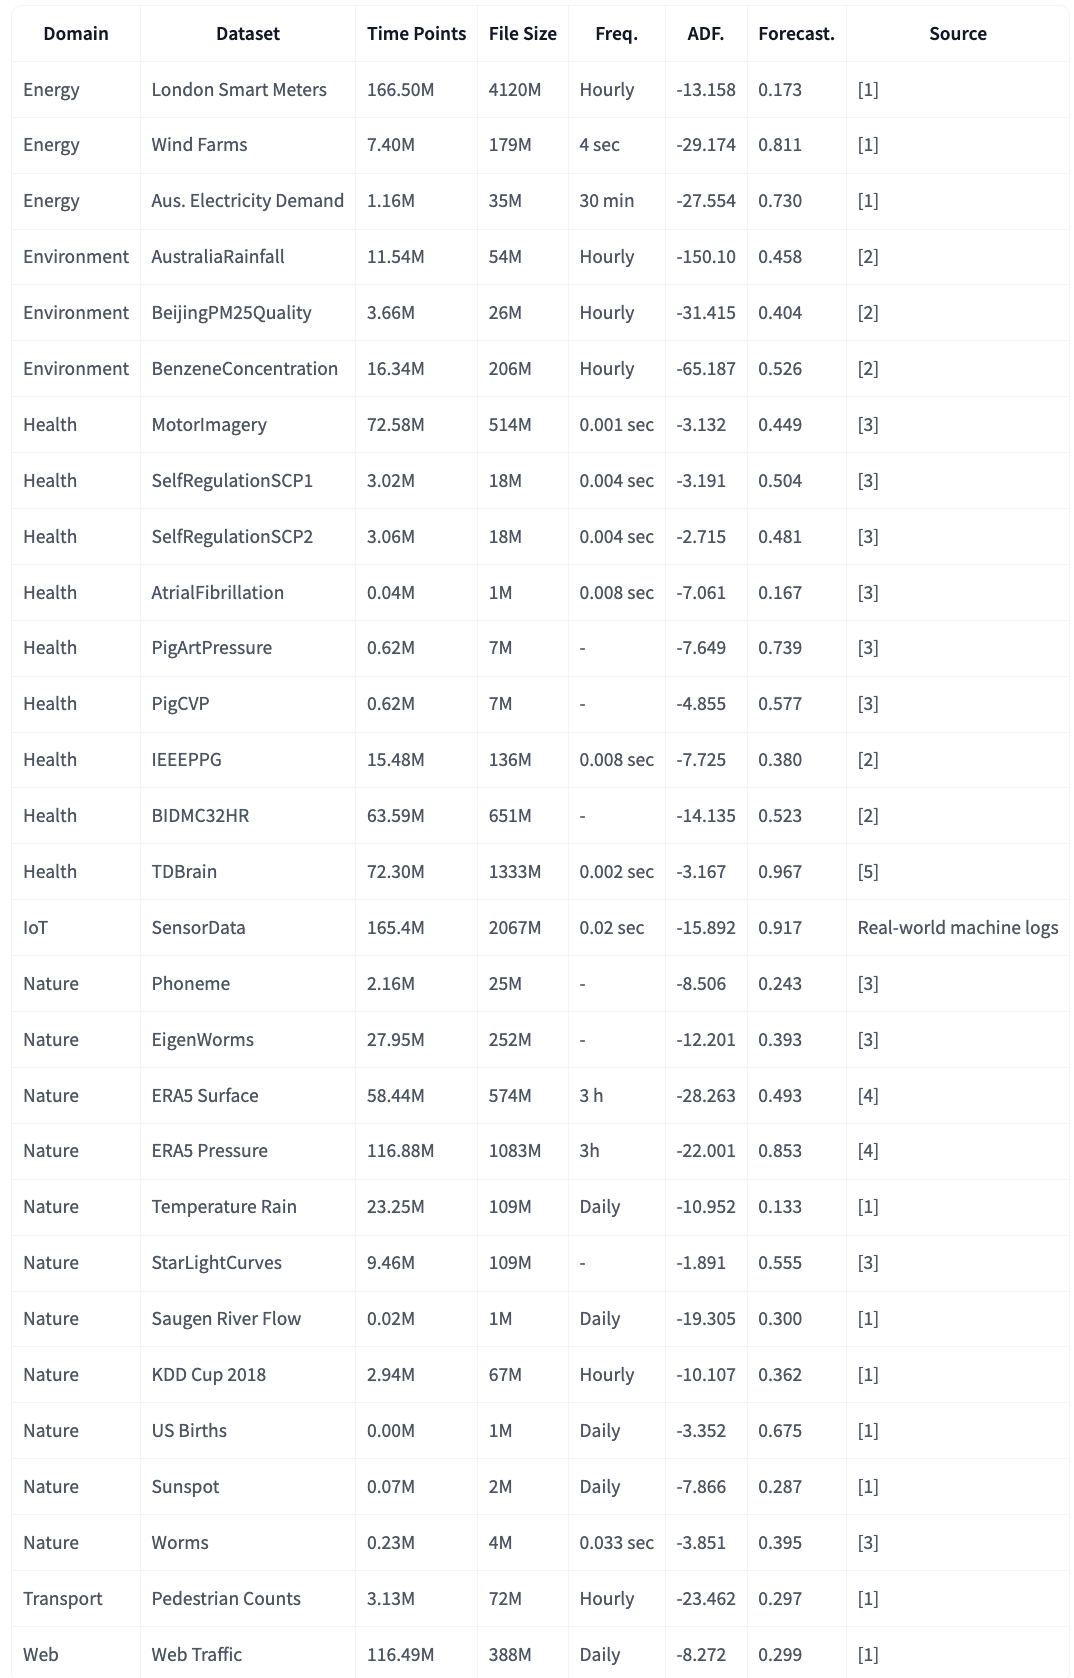

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from lagllama.lag_llama.gluon.estimator import LagLlamaEstimator

ModuleNotFoundError: No module named 'data.augmentations'